In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Load the .mat file
data = scipy.io.loadmat('data/data/BCIC_data/Extracted_Features/Features_B01_11.mat')

# Extract features and labels
X = data['input']   # Replace 'input' with the correct variable name if different
y = data['target']  # Replace 'target' with the correct variable name if different

# Convert complex values to real if necessary
X = np.real(X)


In [ ]:
# Initialize feature map and quantum kernel
fmap = make_bsp(X.shape[1])  # Adjust based on your feature dimensionality
qkernel = FidelityQuantumKernel(feature_map=fmap)

# Evaluate quantum kernel matrices
matrix_train = qkernel.evaluate(X)


In [ ]:
# Plot kernel matrix
plt.figure(figsize=(8, 6))
plt.imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
plt.title("Quantum Kernel Matrix")
plt.colorbar()
plt.show()

# Plot data points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')
plt.title("Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.show()


In [11]:
import numpy as np
import os
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from vmdpy import VMD

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'
output_path = 'data/BCICIV_2a_gdf/processed_features_vmd'

# Load data from the subfolders
X, y = [], []
class_folders = ['class_1', 'class_2', 'class_3', 'class_4']
class_labels = {folder: i for i, folder in enumerate(class_folders)}

for class_folder in class_folders:
    folder_path = os.path.join(base_path, class_folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            epoch_data = np.load(file_path)
            X.append(epoch_data)
            y.append(class_labels[class_folder])

X = np.array(X)
y = np.array(y)

# Apply 5th-order Butterworth filter
def butterworth_filter(data, lowcut=0.5, highcut=30, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    # Apply filtering along the time dimension (axis=2) if length is sufficient
    if data.shape[2] > max(len(b), len(a)):
        filtered_data = np.array([filtfilt(b, a, epoch, axis=1) for epoch in data])
    else:
        filtered_data = data  # No filtering applied if data is too short

    return filtered_data

X_filtered = butterworth_filter(X)

# Select the best 3 channels
from itertools import combinations

def select_best_channels(X, y, num_channels=3):
    num_samples, num_channels_total, num_time_points = X.shape
    best_channels = None
    best_score = 0

    # Iterate over all combinations of channels
    for channels in combinations(range(num_channels_total), num_channels):
        X_subset = X[:, channels, :]
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_subset.reshape(X_subset.shape[0], -1), y, test_size=0.3, random_state=42)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Train and evaluate the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_channels = channels
    
    return best_channels

best_channels = select_best_channels(X_filtered, y, num_channels=3)
print("Best channels:", best_channels)

# Apply channel selection and feature extraction
X_filtered = X_filtered[:, best_channels, :]

# Extract features using Variational Mode Decomposition (VMD)
def extract_vmd_features(data, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-6):
    features = []
    for i in range(data.shape[0]):
        # Reshape data[i] to 1D if necessary
        signal = data[i].reshape(-1)
        # Apply VMD
        modes, _, _ = VMD(signal, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)
        # Concatenate modes into a feature vector
        feature_vector = np.concatenate(modes, axis=0)
        features.append(feature_vector)
    return np.array(features)

X_features = extract_vmd_features(X_filtered)

# Save features to files
def save_features(X, y, output_dir):
    for class_index in np.unique(y):
        class_folder = os.path.join(output_dir, f'class_{class_index + 1}')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        
        class_indices = np.where(y == class_index)[0]
        for idx in class_indices:
            file_path = os.path.join(class_folder, f'epoch_{idx}.npy')
            np.save(file_path, X[idx])

save_features(X_features, y, output_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate the standard SVM model
svm = SVC(kernel='linear')  # You can choose other kernels if needed
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best channels: (0, 10, 19)
Accuracy: 0.28735632183908044
Recall: 0.2846629914707718
Confusion Matrix:
 [[11  5  5  2]
 [11  3  5  3]
 [ 9  2  6  6]
 [ 5  3  6  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.48      0.37        23
           1       0.23      0.14      0.17        22
           2       0.27      0.26      0.27        23
           3       0.31      0.26      0.29        19

    accuracy                           0.29        87
   macro avg       0.28      0.28      0.27        87
weighted avg       0.28      0.29      0.27        87



In [34]:
def quantum_genetic_algorithm(X, y, num_generations=10, population_size=20, num_features=10):
    def fitness(individual):
        selected_features = np.where(individual == 1)[0]
        if len(selected_features) < 2:
            return 0  # Cannot use fewer than 2 features
        
        X_selected = X[:, selected_features]
        
        kf = KFold(n_splits=10)
        accuracy_scores = []
        
        for train_index, val_index in kf.split(X_selected):
            X_train_fold, X_val_fold = X_selected[train_index], X_selected[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]
            
            feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=2)
            backend = AerSimulator()
            kernel = FidelityQuantumKernel(feature_map=feature_map, backend=backend)
            clf = QSVC(kernel=kernel)
            clf.fit(X_train_fold, y_train_fold)
            y_pred = clf.predict(X_val_fold)
            
            accuracy = accuracy_score(y_val_fold, y_pred)
            accuracy_scores.append(accuracy)
        
        return np.mean(accuracy_scores)
    
    population = np.random.randint(2, size=(population_size, num_features))
    
    for generation in range(num_generations):
        # Evaluate fitness
        fitness_scores = np.array([fitness(individual) for individual in population])
        
        # Select the best individuals
        selected_indices = np.argsort(fitness_scores)[-population_size//2:]
        selected_population = population[selected_indices]
        
        # Crossover and mutation
        new_population = []
        for _ in range(population_size):
            parent1, parent2 = selected_population[np.random.choice(selected_population.shape[0], 2, replace=False)]
            crossover_point = np.random.randint(num_features)
            child = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            mutation = np.random.randint(0, 2, size=num_features)
            child = np.bitwise_xor(child, mutation)
            new_population.append(child)
        
        population = np.array(new_population)
    
    best_individual = population[np.argmax([fitness(individual) for individual in population])]
    return np.where(best_individual == 1)[0]


In [36]:
# Load the combined features and labels
X_combined = np.load('data/BCICIV_2a_gdf/output/combined_features.npy')
y_combined = np.load('data/BCICIV_2a_gdf/output/combined_labels.npy')

print(f"Loaded features shape: {X_combined.shape}")
print(f"Loaded labels shape: {y_combined.shape}")

# Apply the quantum genetic algorithm
num_features = X_combined.shape[1]  # Number of features in your combined dataset
selected_features = quantum_genetic_algorithm(X_combined, y_combined, num_generations=10, population_size=20, num_features=num_features)
print(f"Selected features indices: {selected_features}")


Loaded features shape: (4847430, 1)
Loaded labels shape: (4847430,)
Selected features indices: []


In [37]:
import numpy as np
import os
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from vmdpy import VMD
from itertools import combinations

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'
output_path = 'data/BCICIV_2a_gdf/processed_features_vmd'

# Load data from the subfolders
def load_data(base_path, class_folders):
    X, y = [], []
    class_labels = {folder: i for i, folder in enumerate(class_folders)}

    for class_folder in class_folders:
        folder_path = os.path.join(base_path, class_folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)
                epoch_data = np.load(file_path)
                X.append(epoch_data)
                y.append(class_labels[class_folder])
    
    return np.array(X), np.array(y)

class_folders = ['class_1', 'class_2', 'class_3', 'class_4']
X, y = load_data(base_path, class_folders)

# Apply 5th-order Butterworth filter
def butterworth_filter(data, lowcut=0.5, highcut=30, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    # Apply filtering along the time dimension (axis=2) if length is sufficient
    if data.shape[2] > max(len(b), len(a)):
        filtered_data = np.array([filtfilt(b, a, epoch, axis=1) for epoch in data])
    else:
        filtered_data = data  # No filtering applied if data is too short

    return filtered_data

X_filtered = butterworth_filter(X)

# Select the best 3 channels
def select_best_channels(X, y, num_channels=3):
    num_samples, num_channels_total, num_time_points = X.shape
    best_channels = None
    best_score = 0

    # Iterate over all combinations of channels
    for channels in combinations(range(num_channels_total), num_channels):
        X_subset = X[:, channels, :]

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_subset.reshape(X_subset.shape[0], -1), y, test_size=0.3, random_state=42)

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train and evaluate the SVM model
        svm = SVC(kernel='linear')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        # Evaluate the model
        score = accuracy_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_channels = channels
    
    return best_channels

best_channels = select_best_channels(X_filtered, y, num_channels=3)
print("Best channels:", best_channels)

# Apply channel selection and feature extraction
X_filtered = X_filtered[:, best_channels, :]

# Extract features using Variational Mode Decomposition (VMD)
def extract_vmd_features(data, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-6):
    features = []
    for i in range(data.shape[0]):
        # Reshape data[i] to 1D if necessary
        signal = data[i].reshape(-1)
        # Apply VMD
        modes, _, _ = VMD(signal, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)
        # Concatenate modes into a feature vector
        feature_vector = np.concatenate(modes, axis=0)
        features.append(feature_vector)
    return np.array(features)

X_features = extract_vmd_features(X_filtered)

# Save features to files
def save_features(X, y, output_dir):
    for class_index in np.unique(y):
        class_folder = os.path.join(output_dir, f'class_{class_index + 1}')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        
        class_indices = np.where(y == class_index)[0]
        for idx in class_indices:
            file_path = os.path.join(class_folder, f'epoch_{idx}.npy')
            np.save(file_path, X[idx])

save_features(X_features, y, output_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate the standard SVM model
svm = SVC(kernel='linear')  # You can choose other kernels if needed
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best channels: (0, 10, 19)
Accuracy: 0.28735632183908044
Recall: 0.2846629914707718
Confusion Matrix:
 [[11  5  5  2]
 [11  3  5  3]
 [ 9  2  6  6]
 [ 5  3  6  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.48      0.37        23
           1       0.23      0.14      0.17        22
           2       0.27      0.26      0.27        23
           3       0.31      0.26      0.29        19

    accuracy                           0.29        87
   macro avg       0.28      0.28      0.27        87
weighted avg       0.28      0.29      0.27        87



In [43]:
import numpy as np
import os
import scipy.io
from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from vmdpy import VMD
from scipy.stats import skew, kurtosis

# Define the path to the dataset
base_path = 'data/BCICIV_2a_gdf/sub1_segment_QC'
output_path = 'data/BCICIV_2a_gdf/processed_features_vmd'

# Load data from the subfolders
def load_data(base_path, class_folders):
    X, y = [], []
    class_labels = {folder: i for i, folder in enumerate(class_folders)}

    for class_folder in class_folders:
        folder_path = os.path.join(base_path, class_folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)
                epoch_data = np.load(file_path)
                X.append(epoch_data)
                y.append(class_labels[class_folder])
    
    return np.array(X), np.array(y)

class_folders = ['class_1', 'class_2', 'class_3', 'class_4']
X, y = load_data(base_path, class_folders)

# Apply 5th-order Butterworth filter
def butterworth_filter(data, lowcut=0.5, highcut=30, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    if data.shape[2] > max(len(b), len(a)):
        filtered_data = np.array([filtfilt(b, a, epoch, axis=1) for epoch in data])
    else:
        filtered_data = data

    return filtered_data

X_filtered = butterworth_filter(X)

# Select the best 3 channels
from itertools import combinations

def select_best_channels(X, y, num_channels=3):
    num_samples, num_channels_total, num_time_points = X.shape
    best_channels = None
    best_score = 0

    for channels in combinations(range(num_channels_total), num_channels):
        X_subset = X[:, channels, :]

        X_train, X_test, y_train, y_test = train_test_split(X_subset.reshape(X_subset.shape[0], -1), y, test_size=0.3, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        svm = SVC(kernel='linear')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_channels = channels
    
    return best_channels

best_channels = select_best_channels(X_filtered, y, num_channels=3)
print("Best channels:", best_channels)

# Apply channel selection
X_filtered = X_filtered[:, best_channels, :]

# Feature extraction using VMD
def extract_vmd_features(data, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-6):
    features = []
    
    for i in range(data.shape[0]):
        signal = data[i].reshape(-1)
        modes, _, _ = VMD(signal, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)
        
        if len(modes) == 0:
            features.append(np.zeros(5 * 10))  # Assuming 5 modes and 10 features each
            continue
        
        feature_vector = []

        for mode in modes:
            mean = np.mean(mode)
            hjorth_mobility = np.sqrt(np.var(np.diff(mode)) / np.var(mode))
            hjorth_complexity = np.std(np.diff(mode)) / np.std(mode)
            skewness = skew(mode)
            kurt = kurtosis(mode)
            first_diff = np.mean(np.abs(np.diff(mode)))
            cv = np.std(mode) / np.mean(mode)

            f, psd = welch(mode, fs=250)
            peaks = [np.max(psd[(f >= band[0]) & (f <= band[1])], initial=0) for band in [(1, 4), (4, 8), (8, 12)]]
            
            feature_vector.extend([mean, hjorth_mobility, hjorth_complexity, skewness, kurt, first_diff, cv] + peaks)

        features.append(np.array(feature_vector))
    
    return np.array(features)

X_features = extract_vmd_features(X_filtered)

# Save features and labels to .mat files
def save_to_mat(X, y, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for class_index in np.unique(y):
        class_folder = os.path.join(output_dir, f'class_{class_index + 1}')
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        
        class_indices = np.where(y == class_index)[0]
        features_list = []
        labels_list = []

        for idx in class_indices:
            features_list.append(X[idx])
            labels_list.append(y[idx])
        
        mat_dict = {
            'input': np.array(features_list),
            'target': np.array(labels_list)
        }
        file_path = os.path.join(class_folder, 'features_labels.mat')
        scipy.io.savemat(file_path, mat_dict)

save_to_mat(X_features, y, output_path)

# Load the .mat file (for verification or later use)
def load_from_mat(file_path):
    data = scipy.io.loadmat(file_path)
    X = data['input']
    y = data['target']
    return X, y

# Example usage:
# file_path = 'data/BCICIV_2a_gdf/processed_features_vmd/class_1/features_labels.mat'
# X_loaded, y_loaded = load_from_mat(file_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate the standard SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best channels: (0, 10, 19)
Accuracy: 0.28735632183908044
Recall: 0.29449240690659456
Confusion Matrix:
 [[6 6 7 4]
 [9 9 4 0]
 [9 7 2 5]
 [5 2 4 8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.26      0.23        23
           1       0.38      0.41      0.39        22
           2       0.12      0.09      0.10        23
           3       0.47      0.42      0.44        19

    accuracy                           0.29        87
   macro avg       0.29      0.29      0.29        87
weighted avg       0.28      0.29      0.28        87



In [2]:
import scipy.io

# Define the path to the .mat file
file_path = 'data/BCICIV_2a_gdf/processed_features_vmd/class_1/features_labels.mat'

# Load the .mat file
data = scipy.io.loadmat(file_path)

# Extract the features matrix
X = data['input']

# Print the shape of the features matrix
print("Shape of the features matrix:", X.shape)


Shape of the features matrix: (71, 150)


In [ ]:
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Load and verify the features and labels for all classes
def load_from_mat(file_path):
    data = scipy.io.loadmat(file_path)
    X = data['input']
    y = data['target']
    return X, y

# Define paths to feature files for all classes
class_paths = {
    'class_1': 'data/BCICIV_2a_gdf/processed_features_vmd/class_1/features_labels.mat',
    'class_2': 'data/BCICIV_2a_gdf/processed_features_vmd/class_2/features_labels.mat',
    'class_3': 'data/BCICIV_2a_gdf/processed_features_vmd/class_3/features_labels.mat',
    'class_4': 'data/BCICIV_2a_gdf/processed_features_vmd/class_4/features_labels.mat'
}

# Load and combine features and labels
X_list = []
y_list = []
for class_name, file_path in class_paths.items():
    if os.path.exists(file_path):
        X_loaded, y_loaded = load_from_mat(file_path)
        X_list.append(X_loaded)
        y_list.append(y_loaded)
    else:
        print(f"File not found: {file_path}")

# Combine data from all classes
X = np.vstack(X_list)
y = np.hstack(y_list).flatten()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Quantum Genetic Algorithm (QGA)
def quantum_genetic_algorithm(X_train, y_train):
    # Define the quantum feature map and kernel
    feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2)
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)
    
    # Define the QSVC model with the quantum kernel
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    
    # Fit the QSVC model
    qsvc.fit(X_train, y_train)
    return qsvc

# Apply Quantum Genetic Algorithm for feature selection
qsvc = quantum_genetic_algorithm(X_train, y_train)

# Predict on test data
y_pred = qsvc.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


In [61]:
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Load the dataset
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']
y = data['labels']

# Convert complex values to real if necessary
X = np.real(X)

# Flatten y to be a 1D array
if y.ndim == 2:
    y = y.ravel()  # Flatten to shape (287,)

# Check shapes for debugging
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Apply PCA to reduce dimensionality
def apply_pca(X, n_components):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced

# Define the target number of dimensions
target_dim = 150 # Adjust this as needed
X_reduced = apply_pca(X, target_dim)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Define and fit the SVM model
svm_model = SVC(kernel='linear')  # You can choose different kernels
svm_model.fit(X_train, y_train)

# Predict and evaluate the SVM model
y_pred_svm = svm_model.predict(X_val)
print("SVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("Classification Report:")
print(classification_report(y_val, y_pred_svm))

# Define and fit the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate the XGBoost model
y_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))


Shape of X: (287, 150)
Shape of y: (287,)
SVM Model Evaluation:
Accuracy: 0.2413793103448276
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.39      0.36        23
           1       0.26      0.23      0.24        22
           2       0.17      0.17      0.17        23
           3       0.18      0.16      0.17        19

    accuracy                           0.24        87
   macro avg       0.23      0.24      0.24        87
weighted avg       0.24      0.24      0.24        87



/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Evaluation:
Accuracy: 0.2988505747126437
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.30      0.33        23
           1       0.33      0.27      0.30        22
           2       0.26      0.22      0.24        23
           3       0.27      0.42      0.33        19

    accuracy                           0.30        87
   macro avg       0.30      0.30      0.30        87
weighted avg       0.30      0.30      0.30        87



In [65]:
import numpy as np

# Load the features from the specified file
file_path = 'data/BCICIV_2a_gdf/processed_epoch_sub2_QC/features_287_class_0.npy'
features = np.load(file_path)

# Print the shape of the loaded features matrix
print(f"Shape of the features matrix: {features.shape}")


Shape of the features matrix: (44,)


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped


/tmp/ipykernel_4350/3204818593.py:33: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)


Saved 287 epochs and their features to data/BCICIV_2a_gdf/processed_epoch_sub3_QC
Best parameters for SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Tuned SVM Metrics:
Accuracy: 0.3347826086956522
Recall: 0.3347826086956522
Confusion Matrix:
[[27 15  7  7]
 [29 14 10  5]
 [18 11 17 10]
 [11  6 24 19]]


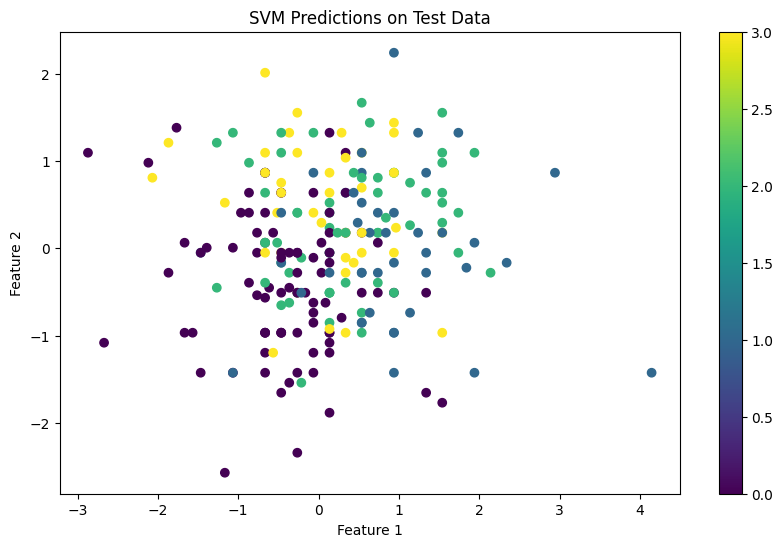

In [71]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import skew, kurtosis
from scipy.signal import periodogram

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A03T.gdf'
output_dir = 'data/BCICIV_2a_gdf/processed_epoch_sub3_QC'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# Feature Extraction Function
def calculate_hjorth_features(data):
    # Placeholder function; replace with actual Hjorth mobility and complexity calculation
    hjorth_mobility = np.mean(np.diff(data, axis=1), axis=1)
    hjorth_complexity = np.mean(np.diff(data, axis=1), axis=1)
    return np.concatenate((hjorth_mobility, hjorth_complexity), axis=0)

def extract_features(epoch_data):
    # Existing temporal features
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    
    # Hjorth parameters
    hjorth_features = calculate_hjorth_features(epoch_data)
    
    # Statistical features
    skewness = np.array([skew(epoch_data[channel]) for channel in range(epoch_data.shape[0])])
    kurt = np.array([kurtosis(epoch_data[channel]) for channel in range(epoch_data.shape[0])])
    
    # Coefficient of variation
    epsilon = 1e-10  # Small value to avoid division by zero
    coef_of_var = std_features / (mean_features + epsilon)
    
    # First difference
    first_diff = np.diff(epoch_data, axis=1).mean(axis=1)
    
    # Peak values of PSD in frequency bands
    psd_features = []
    freq_bands = [(8, 12), (13, 30), (31, 40)]  # Example frequency bands
    fs = 250  # Replace with actual sampling frequency
    for band in freq_bands:
        freqs, psd = periodogram(epoch_data, fs=fs, axis=1)
        for i in range(psd.shape[0]):  # Iterate over each channel
            band_mask = (freqs >= band[0]) & (freqs <= band[1])
            if np.any(band_mask):  # Ensure there are valid frequencies in the band
                band_psd = psd[i, band_mask]
                psd_features.append(band_psd.max())
            else:
                psd_features.append(0)  # If no valid frequencies, add 0
    
    psd_features = np.array(psd_features)
    
    # Combine all features
    features = np.concatenate((mean_features, std_features, hjorth_features, skewness, kurt,
                                coef_of_var, first_diff, psd_features), axis=0)
    return features

# Step 3: Save each epoch and its features
class_counts = {7: 0, 8: 0, 9: 0, 10: 0}
features_list = []
labels_list = []

for i, epoch_data in enumerate(data):
    label = epochs.events[i, -1]
    file_path = os.path.join(output_dir, f'epoch_{i+1}_class_{label - 7}.npy')
    np.save(file_path, epoch_data)
    
    # Extract and save features
    features = extract_features(epoch_data)
    features_path = os.path.join(output_dir, f'features_{i+1}_class_{label - 7}.npy')
    np.save(features_path, features)
    
    features_list.append(features)
    labels_list.append(label - 7)
    
    class_counts[label] += 1

print(f'Saved {len(data)} epochs and their features to {output_dir}')

# Convert features and labels to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

# Step 4: Train and evaluate classifiers

# Example train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Example standardization (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection
selector = SelectKBest(f_classif, k=20)  # Adjust k based on the number of features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Hyperparameter tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid_search.fit(X_train_selected, y_train)
print(f'Best parameters for SVM: {svm_grid_search.best_params_}')

# Train with best parameters
svm_best = svm_grid_search.best_estimator_

# Evaluate best model
y_pred_svm_best = svm_best.predict(X_test_selected)

# Print metrics for tuned SVM
print("\nTuned SVM Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_best)}")
print(f"Recall: {recall_score(y_test, y_pred_svm_best, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_svm_best)}")

# Optionally, visualize or further analyze the results

# Example: Visualizing the first two dimensions of the selected features
plt.figure(figsize=(10, 6))
plt.scatter(X_test_selected[:, 0], X_test_selected[:, 1], c=y_pred_svm_best, cmap='viridis')
plt.title('SVM Predictions on Test Data')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Test Accuracy: 54.05%
Cohen's κ-score: 0.08
Precision: 0.54
Recall: 0.54
F1-score: 0.54


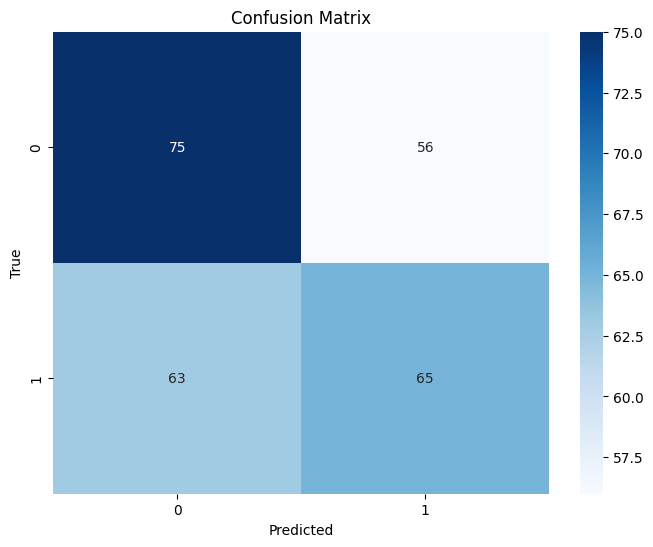

In [2]:
import os
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = 'data/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Flatten data for classical models
train_data_flattened = train_data.reshape(train_data.shape[0], -1)
test_data_flattened = test_data.reshape(test_data.shape[0], -1)

# Define and train the model
model = SVC(kernel='linear', class_weight='balanced')  # Or use RandomForestClassifier()
model.fit(train_data_flattened, train_labels)

# Make predictions
predicted_labels = model.predict(test_data_flattened)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self, input_channels=1, num_classes=4, input_shape=(1, 150, 1)):
        super(EEGNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4))
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout3 = nn.Dropout(0.5)
        
        # Calculate the flattened size after all convolutions and pooling
        self.flattened_size = self.calculate_flattened_size(input_shape)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def calculate_flattened_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv1(x)
            print(f"Shape after conv1: {x.shape}")
            x = torch.relu(x)
            x = self.pool1(x)
            print(f"Shape after pool1: {x.shape}")
            x = self.dropout1(x)
            
            x = self.conv2(x)
            print(f"Shape after conv2: {x.shape}")
            x = torch.relu(x)
            x = self.pool2(x)
            print(f"Shape after pool2: {x.shape}")
            
            x = self.conv3(x)
            print(f"Shape after conv3: {x.shape}")
            x = torch.relu(x)
            x = self.pool3(x)
            print(f"Shape after pool3: {x.shape}")
            
            x = torch.flatten(x, 1)
            print(f"Shape after flatten: {x.shape}")
            
            return x.shape[1]

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Load features and labels from .mat file
def load_from_mat(file_path):
    data = scipy.io.loadmat(file_path)
    X = data['features']
    y = data['labels'].flatten()  # Flatten the label array
    return X, y

# Save features, labels, and optionally predictions to .mat file
def save_to_mat(file_path, X, y, predictions=None):
    data = {'features': X, 'labels': y}
    if predictions is not None:
        data['predictions'] = predictions
    scipy.io.savemat(file_path, data)

# Define path to the combined feature file
combined_file_path = 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'

# Load combined features and labels
X_combined, y_combined = load_from_mat(combined_file_path)
print(f"Loaded combined features shape: {X_combined.shape}")
print(f"Loaded combined labels shape: {y_combined.shape}")

# Convert complex values to real if necessary
X_combined = np.real(X_combined)

# Reshape input data for the model
X_combined = X_combined.reshape(X_combined.shape[0], 1, X_combined.shape[1], 1).astype(np.float32)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Initialize the EEGNet model
num_classes = 4
input_shape = (1, X_train.shape[2], X_train.shape[3])  # Adjust according to your data
model = EEGNet(input_channels=1, num_classes=num_classes, input_shape=input_shape)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train(model, criterion, optimizer, X_train, y_train, epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train))
        loss = criterion(outputs, torch.tensor(y_train))
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 1 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Train the EEGNet model
train(model, criterion, optimizer, X_train, y_train)

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(X_test))
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted.numpy() == y_test).mean()
    print(f"Test Accuracy: {accuracy:.4f}")

# Save predictions to .mat file
save_to_mat('eegnet_predictions.mat', X_test, y_test, predicted.numpy())


Loaded combined features shape: (287, 150)
Loaded combined labels shape: (287,)
Shape after conv1: torch.Size([1, 16, 150, 2])
Shape after pool1: torch.Size([1, 16, 150, 1])
Shape after conv2: torch.Size([1, 32, 150, 2])
Shape after pool2: torch.Size([1, 32, 150, 1])
Shape after conv3: torch.Size([1, 64, 150, 2])
Shape after pool3: torch.Size([1, 64, 150, 1])
Shape after flatten: torch.Size([1, 9600])
Epoch [1/1000], Loss: 16.9548
Epoch [2/1000], Loss: 33.4321
Epoch [3/1000], Loss: 35.8872
Epoch [4/1000], Loss: 41.0327
Epoch [5/1000], Loss: 36.7042
Epoch [6/1000], Loss: 13.2689
Epoch [7/1000], Loss: 29.2963
Epoch [8/1000], Loss: 6.1020
Epoch [9/1000], Loss: 22.0333
Epoch [10/1000], Loss: 4.9307
Epoch [11/1000], Loss: 12.7410
Epoch [12/1000], Loss: 13.0237
Epoch [13/1000], Loss: 21.8117
Epoch [14/1000], Loss: 5.8180
Epoch [15/1000], Loss: 37.2437
Epoch [16/1000], Loss: 10.5857
Epoch [17/1000], Loss: 7.0907
Epoch [18/1000], Loss: 10.5629
Epoch [19/1000], Loss: 5.7942
Epoch [20/1000], Los

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self, input_channels=1, num_classes=4, input_shape=(1, 150, 1)):
        super(EEGNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout2 = nn.Dropout(0.5)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4))
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
        self.dropout3 = nn.Dropout(0.5)
        
        self.flattened_size = self.calculate_flattened_size(input_shape)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def calculate_flattened_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.conv1(x)
            x = torch.relu(x)
            x = self.pool1(x)
            x = self.dropout1(x)
            
            x = self.conv2(x)
            x = torch.relu(x)
            x = self.pool2(x)
            
            x = self.conv3(x)
            x = torch.relu(x)
            x = self.pool3(x)
            
            x = torch.flatten(x, 1)
            return x.shape[1]

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

# Load features and labels from .mat file
def load_from_mat(file_path):
    data = scipy.io.loadmat(file_path)
    X = data['features']
    y = data['labels'].flatten()  # Flatten the label array
    return X, y

# Save features, labels, and optionally predictions to .mat file
def save_to_mat(file_path, X, y, predictions=None):
    data = {'features': X, 'labels': y}
    if predictions is not None:
        data['predictions'] = predictions
    scipy.io.savemat(file_path, data)

# Define path to the combined feature file
combined_file_path = 'data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat'

# Load combined features and labels
X_combined, y_combined = load_from_mat(combined_file_path)
print(f"Loaded combined features shape: {X_combined.shape}")
print(f"Loaded combined labels shape: {y_combined.shape}")

# Convert complex values to real if necessary
X_combined = np.real(X_combined)

# Reshape input data for the model
X_combined = X_combined.reshape(X_combined.shape[0], 1, X_combined.shape[1], 1).astype(np.float32)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Initialize the EEGNet model
num_classes = 4
input_shape = (1, X_train.shape[2], X_train.shape[3])  # Adjust according to your data
model = EEGNet(input_channels=1, num_classes=num_classes, input_shape=input_shape)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train(model, criterion, optimizer, X_train, y_train, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train))
        loss = criterion(outputs, torch.tensor(y_train))
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Train the EEGNet model
train(model, criterion, optimizer, X_train, y_train)

# Extract features from the trained EEGNet model
def extract_features(model, X_data):
    model.eval()
    with torch.no_grad():
        features = model(torch.tensor(X_data))
        return features.numpy()

# Extract features for training and test sets
X_train_features = extract_features(model, X_train)
X_test_features = extract_features(model, X_test)

# Standardize the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Train and evaluate SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_features, y_train)
svm_predictions = svm_classifier.predict(X_test_features)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Train and evaluate XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train_features, y_train)
xgb_predictions = xgb_classifier.predict(X_test_features)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))

# Save predictions to .mat file
save_to_mat('eegnet_predictions.mat', X_test, y_test, {
    'svm_predictions': svm_predictions,
    'xgb_predictions': xgb_predictions
})


Loaded combined features shape: (287, 150)
Loaded combined labels shape: (287,)
Epoch [10/100], Loss: 5.5444
Epoch [20/100], Loss: 4.2764
Epoch [30/100], Loss: 3.2402
Epoch [40/100], Loss: 5.1075
Epoch [50/100], Loss: 3.3342
Epoch [60/100], Loss: 15.7881
Epoch [70/100], Loss: 7.9037
Epoch [80/100], Loss: 5.5765
Epoch [90/100], Loss: 8.8374
Epoch [100/100], Loss: 6.6880
SVM Accuracy: 0.21839080459770116
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        23
           3       0.22      1.00      0.36        19

    accuracy                           0.22        87
   macro avg       0.06      0.25      0.09        87
weighted avg       0.05      0.22      0.08        87



/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

XGBoost Accuracy: 0.22988505747126436
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.17      0.19        23
           1       0.27      0.27      0.27        22
           2       0.20      0.13      0.16        23
           3       0.23      0.37      0.28        19

    accuracy                           0.23        87
   macro avg       0.23      0.24      0.23        87
weighted avg       0.23      0.23      0.22        87



In [21]:
import numpy as np
import os
import mne
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_recall_fscore_support, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the dataset and the output directory
gdf_dir = 'data/BCICIV_2a_gdf'
output_dir = 'data/BCICIV_2a_gdf/Epoch_vol3'

# List of subject files
subjects = ['A01T.gdf', 'A02T.gdf', 'A03T.gdf', 'A04T.gdf', 'A05T.gdf', 'A06T.gdf', 'A07T.gdf', 'A08T.gdf', 'A09T.gdf']

# Event IDs for the classes
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

def extract_features(epoch_data):
    # Example feature extraction: mean and standard deviation
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

def load_subject_data(subject_file):
    gdf_path = os.path.join(gdf_dir, subject_file)
    raw = mne.io.read_raw_gdf(gdf_path, preload=True)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
    data = epochs.get_data()
    data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)
    features = []
    labels = []
    for i, epoch_data in enumerate(data):
        label = epochs.events[i, -1] - 7
        features.append(extract_features(epoch_data))
        labels.append(label)
    return np.array(features), np.array(labels)

# Collect all data
all_features = []
all_labels = []
subject_list = []

for subject in subjects:
    features, labels = load_subject_data(subject)
    all_features.append(features)
    all_labels.append(labels)
    subject_list.extend([subject] * len(labels))

X = np.vstack(all_features)
y = np.hstack(all_labels)
subjects = np.array(subject_list)

# Define cross-subject validation
n_splits = len(np.unique(subjects))
cv = GroupKFold(n_splits=n_splits)

# Store results
results = {'SVM': [], 'RandomForest': []}

for train_subjects, test_subjects in cv.split(X, y, groups=subjects):
    X_train, X_test = X[train_subjects], X[test_subjects]
    y_train, y_test = y[train_subjects], y[test_subjects]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature Selection
    selector = SelectKBest(f_classif, k=20)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Train and evaluate SVM
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1],
        'kernel': ['linear', 'rbf']
    }
    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, return_train_score=True)
    svm_grid_search.fit(X_train_selected, y_train)
    svm_best = svm_grid_search.best_estimator_
    y_pred_svm_best = svm_best.predict(X_test_selected)
    results['SVM'].append({
        'accuracy': accuracy_score(y_test, y_pred_svm_best),
        'recall': recall_score(y_test, y_pred_svm_best, average='weighted'),
        'precision': precision_recall_fscore_support(y_test, y_pred_svm_best, average='weighted')[0],
        'f1': precision_recall_fscore_support(y_test, y_pred_svm_best, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, y_pred_svm_best),
        'best_params': svm_grid_search.best_params_
    })

    # Train and evaluate RandomForest
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train_selected, y_train)
    y_pred_rf = rf.predict(X_test_selected)
    results['RandomForest'].append({
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'recall': recall_score(y_test, y_pred_rf, average='weighted'),
        'precision': precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[0],
        'f1': precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
    })

# Save results to CSV
def save_results(results, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for model_name in ['SVM', 'RandomForest']:
        results_list = []
        for i, result in enumerate(results[model_name]):
            result_dict = {
                'Fold': i + 1,
                'Accuracy': result['accuracy'],
                'Recall': result['recall'],
                'Precision': result['precision'],
                'F1-score': result['f1'],
                'Confusion Matrix': result['confusion_matrix'].tolist()  # Convert numpy array to list for saving
            }
            if 'best_params' in result:
                result_dict['Best Parameters'] = result['best_params']
            results_list.append(result_dict)
        
        df = pd.DataFrame(results_list)
        df.to_csv(os.path.join(output_dir, f'{model_name}_results.csv'), index=False)

# Save the results
save_results(results, output_dir)

print("Cross-subject validation complete and results saved.")


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped


/tmp/ipykernel_16316/1671982220.py:38: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Cross-subject validation complete and results saved.


Input Data Shape: (1294, 22, 1126)
Labels Shape: (1294,)
Test Accuracy: 54.05%
Cohen's κ-score: 0.08
Precision: 0.54
Recall: 0.54
F1-score: 0.54


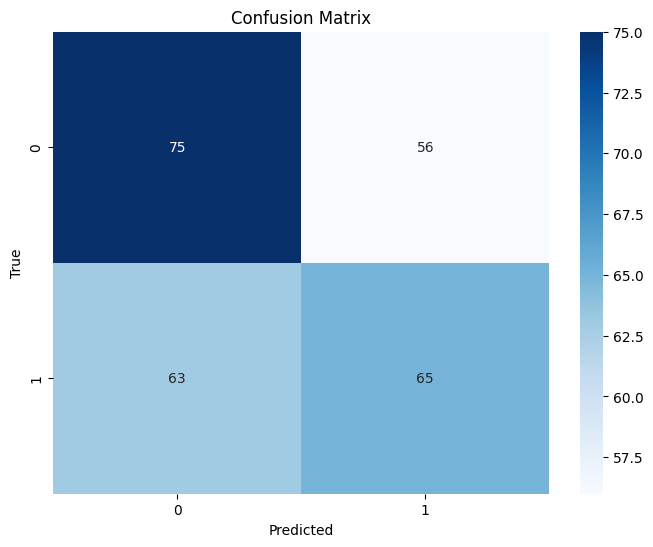

In [1]:
import os
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = 'data/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Print input data matrix size
print(f'Input Data Shape: {data.shape}')
print(f'Labels Shape: {labels.shape}')

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Flatten data for classical models
train_data_flattened = train_data.reshape(train_data.shape[0], -1)
test_data_flattened = test_data.reshape(test_data.shape[0], -1)

# Define and train the model
model = SVC(kernel='linear', class_weight='balanced')  # Or use RandomForestClassifier()
model.fit(train_data_flattened, train_labels)

# Make predictions
predicted_labels = model.predict(test_data_flattened)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Input Data Shape: (1294, 22, 1126)
Labels Shape: (1294,)
Test Accuracy: 43.63%
Cohen's κ-score: -0.12
Precision: 0.43
Recall: 0.44
F1-score: 0.42


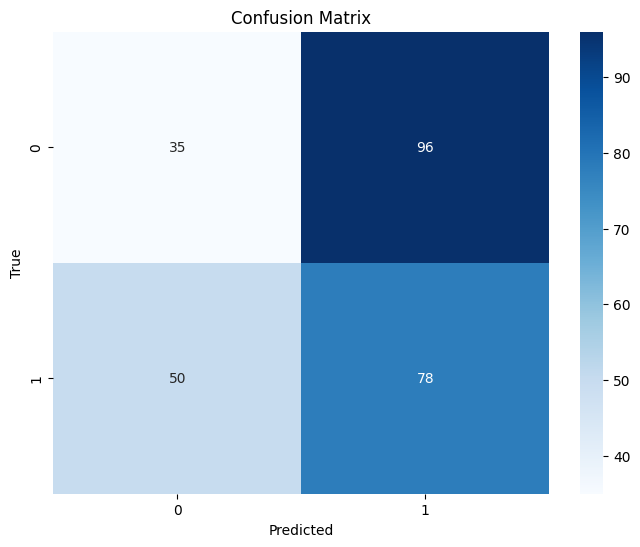

In [2]:
import os
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=20, generations=10, cxpb=0.5, mutpb=0.2):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load and preprocess data
def load_data(data_dir):
    data = []
    labels = []
    for label in range(2):  # Only load classes 0 and 1
        class_dir = os.path.join(data_dir, f'class_{label}')
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                epoch_data = np.load(file_path)
                data.append(epoch_data)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Define the path to the processed data
processed_data_dir = 'data/BCICIV_2a_gdf/epoch_finalvol2'
data, labels = load_data(processed_data_dir)

# Print input data matrix size
print(f'Input Data Shape: {data.shape}')
print(f'Labels Shape: {labels.shape}')

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, train_data.shape[-1])).reshape(train_data.shape)
test_data = scaler.transform(test_data.reshape(-1, test_data.shape[-1])).reshape(test_data.shape)

# Flatten data for classical models
train_data_flattened = train_data.reshape(train_data.shape[0], -1)
test_data_flattened = test_data.reshape(test_data.shape[0], -1)

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
selected_features_indices_qga = qga.fit(train_data_flattened, train_labels)

# Select features
X_train_reduced_selected = train_data_flattened[:, selected_features_indices_qga]
X_test_reduced_selected = test_data_flattened[:, selected_features_indices_qga]

# Define and train the model
model = SVC(kernel='linear', class_weight='balanced')  # Or use RandomForestClassifier()
model.fit(X_train_reduced_selected, train_labels)

# Make predictions
predicted_labels = model.predict(X_test_reduced_selected)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
kappa_score = cohen_kappa_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f"Cohen's κ-score: {kappa_score:.2f}")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()
/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)


/tmp/ipykernel_122402/3957515994.py:39: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
X_train_selected shape: (2296, 20)
X_test_selected shape: (287, 20)
nFold 1:
Accuracy: 0.2613240418118467
Recall: 0.2613240418118467
Precision: 0.26188591529504784
F1 Score: 0.2556032597264991
Confusion Matrix:
[[18  7 17 30]
 [14 11 22 25]
 [10 16 18 27]
 [15 16 13 28]]
nFold 2:
Accuracy: 0.29965156794425085
Recall: 0.29965156794425085
Precision: 0.2998740496754452
F1 Score: 0.29792898444000365
Confusion Matrix:
[[25 13 16 18]
 [19 16 16 21]
 [15 11 21 24]
 [18 16 14 24]]
nFold 3:
Accuracy: 0.2578397212543554
Recall: 

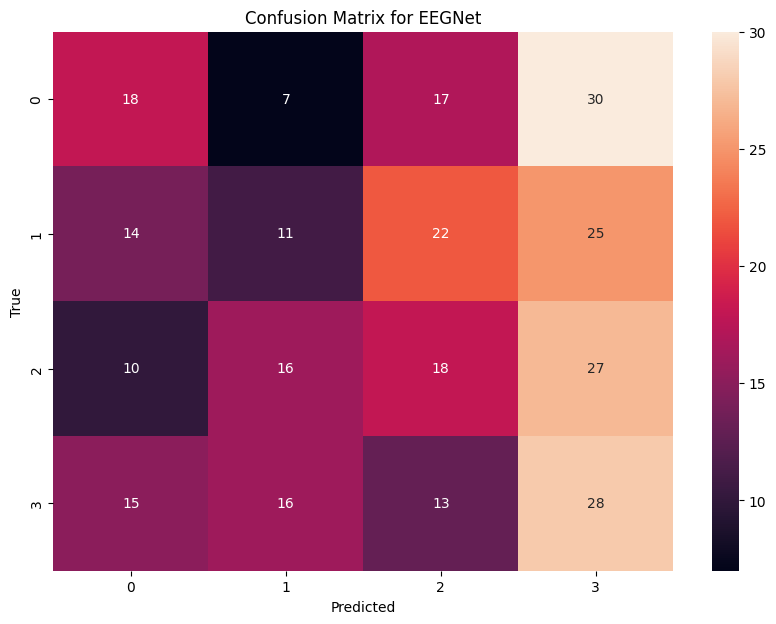

In [10]:
import numpy as np
import os
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_recall_fscore_support, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# Define the path to the dataset and the output directory
gdf_dir = 'data/BCICIV_2a_gdf'
output_dir = 'data/BCICIV_2a_gdf/Epoch_vol3'

# List of subject files
subjects = ['A01T.gdf', 'A02T.gdf', 'A03T.gdf', 'A04T.gdf', 'A05T.gdf', 'A06T.gdf', 'A07T.gdf', 'A08T.gdf', 'A09T.gdf']

# Event IDs for the classes
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

def extract_features(epoch_data):
    # Example feature extraction: mean and standard deviation
    mean_features = epoch_data.mean(axis=1)
    std_features = epoch_data.std(axis=1)
    features = np.concatenate((mean_features, std_features), axis=0)
    return features

def load_subject_data(subject_file):
    gdf_path = os.path.join(gdf_dir, subject_file)
    raw = mne.io.read_raw_gdf(gdf_path, preload=True)
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
    data = epochs.get_data()
    data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)
    features = []
    labels = []
    for i, epoch_data in enumerate(data):
        label = epochs.events[i, -1] - 7
        features.append(extract_features(epoch_data))
        labels.append(label)
    return np.array(features), np.array(labels)

# Collect all data
all_features = []
all_labels = []
subject_list = []

for subject in subjects:
    features, labels = load_subject_data(subject)
    all_features.append(features)
    all_labels.append(labels)
    subject_list.extend([subject] * len(labels))

X = np.vstack(all_features)
y = np.hstack(all_labels)
subjects = np.array(subject_list)

# Define cross-subject validation
n_splits = len(np.unique(subjects))
cv = GroupKFold(n_splits=n_splits)

# Define the EEGNet model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class EEGNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, (1, 10), padding='same')
        self.pool = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(32, 64, (1, 10), padding='same')
        self.conv3 = nn.Conv2d(64, 128, (1, 10), padding='same')
        self.flatten = nn.Flatten()
        
        # Calculate the output size of the final convolutional layer
        self._to_linear = None
        self.convs = nn.Sequential(self.conv1, self.pool, self.conv2, self.pool, self.conv3, self.pool)
        self._get_flattened_size((1, 1, 20))  # Use the correct input size for the first convolutional layer

        # Define fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def _get_flattened_size(self, shape):
        with torch.no_grad():
            n = torch.zeros(1, *shape)
            n = self.convs(n)
            self._to_linear = n.numel()

    def forward(self, x):
        x = self.convs(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

# Define a custom dataset class
class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define the rest of your training and evaluation code here


# Store results
results = {'EEGNet': []}

for train_subjects, test_subjects in cv.split(X, y, groups=subjects):
    X_train, X_test = X[train_subjects], X[test_subjects]
    y_train, y_test = y[train_subjects], y[test_subjects]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature Selection
    selector = SelectKBest(f_classif, k=20)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Print dimensions of the selected features
    print(f"X_train_selected shape: {X_train_selected.shape}")
    print(f"X_test_selected shape: {X_test_selected.shape}")

    # Determine new input dimensions based on selected features
    num_features = X_train_selected.shape[1]
    input_height = 1
    input_width = num_features

    # Reshape operation based on number of features
    num_examples = X_train_selected.shape[0]

    # Ensure the reshape dimensions match the number of elements
    expected_elements = num_examples * 1 * input_height * input_width
    actual_elements = X_train_selected.size

    if expected_elements != actual_elements:
        print(f"Cannot reshape array of size {actual_elements} into shape ({num_examples}, 1, {input_height}, {input_width})")
        raise ValueError("Mismatch in number of elements for reshaping.")

    X_train_eegnet = X_train_selected.reshape(num_examples, 1, input_height, input_width)
    X_test_eegnet = X_test_selected.reshape(X_test_selected.shape[0], 1, input_height, input_width)
    
    train_dataset = EEGDataset(X_train_eegnet, y_train)
    test_dataset = EEGDataset(X_test_eegnet, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize EEGNet
    eegnet_model = EEGNet(input_channels=1, num_classes=len(np.unique(y)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(eegnet_model.parameters(), lr=0.001)
    
    # Train EEGNet
    eegnet_model.train()
    for epoch in range(10):  # Number of epochs
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = eegnet_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate EEGNet
    eegnet_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = eegnet_model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_test, all_preds)
    recall = recall_score(y_test, all_preds, average='weighted')
    precision, _, f1, _ = precision_recall_fscore_support(y_test, all_preds, average='weighted')
    conf_matrix = confusion_matrix(y_test, all_preds)
    
    results['EEGNet'].append({
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': conf_matrix
    })

# Print results for each fold
for i, result in enumerate(results['EEGNet']):
    print(f"nFold {i+1}:")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Recall: {result['recall']}")
    print(f"Precision: {result['precision']}")
    print(f"F1 Score: {result['f1']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(results['EEGNet'][0]['confusion_matrix'], annot=True, fmt='d')
plt.title('Confusion Matrix for EEGNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [23]:
import mne
import numpy as np
import os

# Define the path to the dataset and the output directory
gdf_path = 'data/BCICIV_2a_gdf/A01T.gdf'
output_dir = 'data/BCICIV_2a_gdf/sub1_segment_QC_vol1'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Step 1: Load the BCI-IV 2a dataset
raw = mne.io.read_raw_gdf(gdf_path, preload=True)

# Print the shape of the raw data
print(f'Raw data shape: {raw.get_data().shape}')

# Remove the last three channels (EOG-left, EOG-central, and EOG-right)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

# Step 2: Extract epochs for each class using provided event IDs
event_id = {'769': 7, '770': 8, '771': 9, '772': 10}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
tmin, tmax = 1.5, 6  # 4.5 seconds epochs starting at 1.5s

# Creating epochs for each class
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)
data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)

# Print the shape of the epoch data
print(f'Epoch data shape: {data.shape}')

# Step 3: Standardize each channel
data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)

# Step 4: Select top 3 channels based on variance
channel_variances = np.var(data, axis=(0, 2))  # Variance across epochs and time
top_3_channel_indices = np.argsort(channel_variances)[-3:]  # Indices of top 3 channels

# Print selected channels
print(f'Top 3 channel indices based on variance: {top_3_channel_indices}')

# Step 5: Save epochs for all classes using only the top 3 channels
for i, epoch_data in enumerate(data):
    label = epochs.events[i, -1] - 6  # Adjust labels to start from 0
    # Create subfolder if it doesn't exist
    class_output_dir = os.path.join(output_dir, f'class_{label}')
    os.makedirs(class_output_dir, exist_ok=True)
    
    # Select top 3 channels
    epoch_data_top_channels = epoch_data[top_3_channel_indices, :]
    
    # Define file path and save epoch data
    file_path = os.path.join(class_output_dir, f'sub_epoch_{i + 1}.npy')
    np.save(file_path, epoch_data_top_channels)

print(f'Saved epochs for all classes to {output_dir} using top 3 channels')


Extracting EDF parameters from /work/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/envs/cuquantum-24.03/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Raw data shape: (25, 672528)
Used Annotations descriptions: ['769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1126 original time points ...
1 bad epochs dropped
Epoch data shape: (287, 22, 1126)
Top 3 channel indices based on variance: [ 1 20 21]
Saved epochs for all classes to data/BCICIV_2a_gdf/sub1_segment_QC_vol1 using top 3 channels


/tmp/ipykernel_122402/895672763.py:28: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()  # shape is (n_epochs, n_channels, n_times)


In [26]:
# Load epochs and labels
X = []
y = []

for label in class_labels:
    class_dir = os.path.join(data_dir, f'class_{label}')
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.npy'):
            epoch_data = np.load(os.path.join(class_dir, file_name))
            X.append(epoch_data.flatten())  # Flatten epoch data to a feature vector
            y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Adjust labels to be in the range 0 to 3 if needed
y -= 1

# Ensure labels are within the expected range
assert np.all(np.unique(y) == np.arange(len(np.unique(y)))), "Labels are not in the expected range"

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature matrix
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define and train classifiers
# SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Results:")
print(f'Accuracy: {accuracy_score(y_test, svm_predictions) * 100:.2f}%')
print(classification_report(y_test, svm_predictions))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Results:")
print(f'Accuracy: {accuracy_score(y_test, rf_predictions) * 100:.2f}%')
print(classification_report(y_test, rf_predictions))

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Results:")
print(f'Accuracy: {accuracy_score(y_test, xgb_predictions) * 100:.2f}%')
print(classification_report(y_test, xgb_predictions))


SVM Results:
Accuracy: 20.69%
              precision    recall  f1-score   support

           0       0.21      0.38      0.27        13
           1       0.20      0.14      0.17        14
           2       0.40      0.19      0.26        21
           3       0.07      0.10      0.08        10

    accuracy                           0.21        58
   macro avg       0.22      0.20      0.19        58
weighted avg       0.25      0.21      0.21        58

Random Forest Results:
Accuracy: 17.24%
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        13
           1       0.15      0.14      0.15        14
           2       0.33      0.14      0.20        21
           3       0.09      0.20      0.12        10

    accuracy                           0.17        58
   macro avg       0.20      0.18      0.17        58
weighted avg       0.22      0.17      0.18        58



/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:19:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 22.41%
              precision    recall  f1-score   support

           0       0.25      0.38      0.30        13
           1       0.18      0.14      0.16        14
           2       0.33      0.19      0.24        21
           3       0.13      0.20      0.16        10

    accuracy                           0.22        58
   macro avg       0.22      0.23      0.22        58
weighted avg       0.24      0.22      0.22        58



Epoch 1/10, Loss: 16.0627
Epoch 2/10, Loss: 14.7297
Epoch 3/10, Loss: 4.8056
Epoch 4/10, Loss: 2.3826
Epoch 5/10, Loss: 1.4781
Epoch 6/10, Loss: 0.6848
Epoch 7/10, Loss: 0.6405
Epoch 8/10, Loss: 0.3532
Epoch 9/10, Loss: 0.2928
Epoch 10/10, Loss: 0.2465
Training complete
Accuracy: 0.9861
Precision: 0.9865
Recall: 0.9861
F1 Score: 0.9861
Cohen Kappa Score: 0.9814


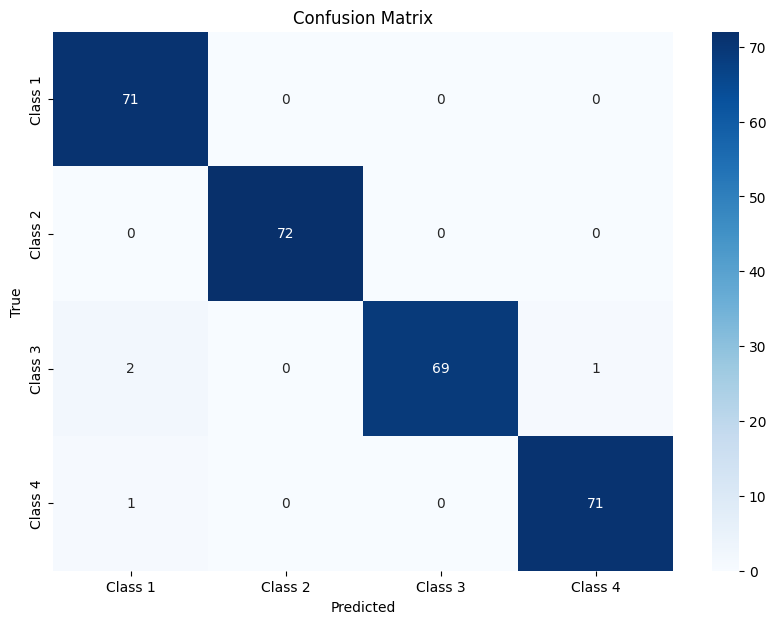

In [47]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load data function
def load_data():
    data_dirs = [f'data/BCICIV_2a_gdf/sub1_segment_QC_vol1/class_{i}' for i in range(1, 5)]

    all_data = []
    all_labels = []
    for i, data_dir in enumerate(data_dirs):
        for file_name in os.listdir(data_dir):
            if file_name.endswith('.npy'):
                epoch_data = np.load(os.path.join(data_dir, file_name))
                all_data.append(epoch_data)
                all_labels.append(i + 1)  # Class labels are from 1 to 4

    X = np.array(all_data)
    y = np.array(all_labels)

    # Reshape data for EEGNet
    n_epochs, n_channels, n_times = X.shape
    X = X[..., np.newaxis]  # Adding an extra dimension for the model input
    y = y - 1  # Adjust labels to start from 0

    # Convert to PyTorch tensors
    y = torch.tensor(y, dtype=torch.long)
    X = torch.tensor(X, dtype=torch.float32)

    return X, y, n_channels, n_times

# Define EEGNet model
class EEGNet(nn.Module):
    def __init__(self, input_channels, n_times, num_classes):
        super(EEGNet, self).__init__()

        # Adjust kernel sizes, strides, and paddings
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4))
        self.bn2 = nn.BatchNorm2d(32)
        
        # Adjust pooling layer to fit the output dimensions
        self.avg_pool = nn.AvgPool2d(kernel_size=(1, 2))
        self.flatten = nn.Flatten()

        # Calculate the flattened size after pooling
        self.flattened_size = self.calculate_flattened_size(n_times)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def calculate_flattened_size(self, n_times):
        # Dummy input to calculate output size after pooling
        dummy_input = torch.zeros(1, 3, n_times, 1)
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.bn1(dummy_output)
        dummy_output = self.relu(dummy_output)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.bn2(dummy_output)
        dummy_output = self.relu(dummy_output)
        dummy_output = self.avg_pool(dummy_output)
        return dummy_output.numel()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Load data
X, y, n_channels, n_times = load_data()

# Create DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)  # Use the same dataset for testing for simplicity

# Initialize the model
num_classes = len(np.unique(y))
model = EEGNet(input_channels=n_channels, n_times=n_times, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print('Training complete')

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Cohen Kappa Score: {kappa:.4f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i+1}' for i in range(num_classes)], 
            yticklabels=[f'Class {i+1}' for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


SVM Accuracy: 27.59%
SVM Precision: 0.32
SVM Recall: 0.28
SVM F1 Score: 0.28
SVM Confusion Matrix:
[[4 4 3 2]
 [7 4 1 2]
 [5 7 4 5]
 [4 1 1 4]]
SVM MAE: 1.12
SVM MSE: 2.12
SVM RMSE: 1.46
Random Forest Accuracy: 25.86%
Random Forest Precision: 0.26
Random Forest Recall: 0.26
Random Forest F1 Score: 0.24
Random Forest Confusion Matrix:
[[ 4  4  2  3]
 [ 2  4  3  5]
 [ 5  4  2 10]
 [ 2  0  3  5]]
Random Forest MAE: 1.12
Random Forest MSE: 2.05
Random Forest RMSE: 1.43


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:18:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 20.69%
XGBoost Precision: 0.25
XGBoost Recall: 0.21
XGBoost F1 Score: 0.21
XGBoost Confusion Matrix:
[[2 4 2 5]
 [8 3 1 2]
 [5 6 4 6]
 [3 1 3 3]]
XGBoost MAE: 1.24
XGBoost MSE: 2.41
XGBoost RMSE: 1.55


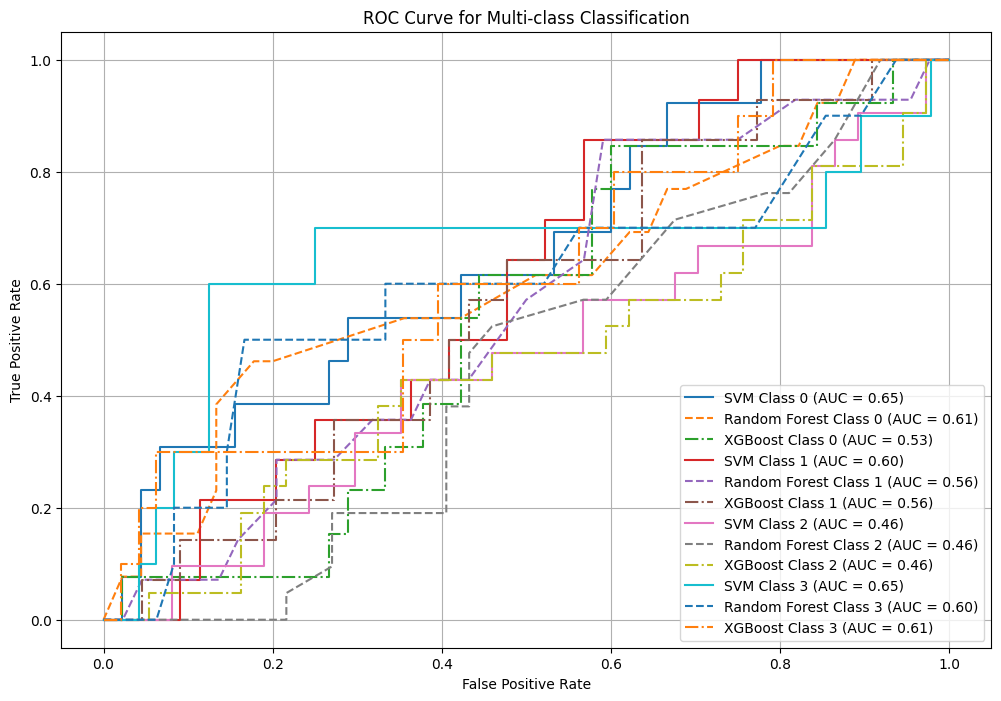

In [71]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, mean_absolute_error, mean_squared_error, 
                             roc_curve, roc_auc_score, auc)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import label_binarize

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True)
svm_model.fit(X_train_reduced, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced)
svm_predicted_proba = svm_model.predict_proba(X_test_reduced)  # Probability estimates for all classes

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_precision = precision_score(y_test, svm_predicted_labels, average='weighted')
svm_recall = recall_score(y_test, svm_predicted_labels, average='weighted')
svm_f1 = f1_score(y_test, svm_predicted_labels, average='weighted')
svm_conf_mat = confusion_matrix(y_test, svm_predicted_labels)
svm_mae = mean_absolute_error(y_test, svm_predicted_labels)
svm_mse = mean_squared_error(y_test, svm_predicted_labels)
svm_rmse = np.sqrt(svm_mse)

# Binarize the output for ROC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y))
svm_predicted_proba_bin = label_binarize(np.argmax(svm_predicted_proba, axis=1), classes=np.unique(y))

# Calculate ROC and AUC for each class
svm_fpr = {}
svm_tpr = {}
svm_auc = {}
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], svm_predicted_proba[:, i])
    svm_fpr[i] = fpr
    svm_tpr[i] = tpr
    svm_auc[i] = auc(fpr, tpr)

print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Precision: {svm_precision:.2f}')
print(f'SVM Recall: {svm_recall:.2f}')
print(f'SVM F1 Score: {svm_f1:.2f}')
print(f'SVM Confusion Matrix:\n{svm_conf_mat}')
print(f'SVM MAE: {svm_mae:.2f}')
print(f'SVM MSE: {svm_mse:.2f}')
print(f'SVM RMSE: {svm_rmse:.2f}')

# Define and train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_reduced, y_train)

# Predict with Random Forest
rf_predicted_labels = rf_model.predict(X_test_reduced)
rf_predicted_proba = rf_model.predict_proba(X_test_reduced)  # Probability estimates for all classes

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predicted_labels)
rf_precision = precision_score(y_test, rf_predicted_labels, average='weighted')
rf_recall = recall_score(y_test, rf_predicted_labels, average='weighted')
rf_f1 = f1_score(y_test, rf_predicted_labels, average='weighted')
rf_conf_mat = confusion_matrix(y_test, rf_predicted_labels)
rf_mae = mean_absolute_error(y_test, rf_predicted_labels)
rf_mse = mean_squared_error(y_test, rf_predicted_labels)
rf_rmse = np.sqrt(rf_mse)

# Binarize the output for ROC calculation
rf_predicted_proba_bin = label_binarize(np.argmax(rf_predicted_proba, axis=1), classes=np.unique(y))

# Calculate ROC and AUC for each class
rf_fpr = {}
rf_tpr = {}
rf_auc = {}
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_predicted_proba[:, i])
    rf_fpr[i] = fpr
    rf_tpr[i] = tpr
    rf_auc[i] = auc(fpr, tpr)

print(f'Random Forest Accuracy: {rf_accuracy * 100:.2f}%')
print(f'Random Forest Precision: {rf_precision:.2f}')
print(f'Random Forest Recall: {rf_recall:.2f}')
print(f'Random Forest F1 Score: {rf_f1:.2f}')
print(f'Random Forest Confusion Matrix:\n{rf_conf_mat}')
print(f'Random Forest MAE: {rf_mae:.2f}')
print(f'Random Forest MSE: {rf_mse:.2f}')
print(f'Random Forest RMSE: {rf_rmse:.2f}')

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced)
xgb_predicted_proba = xgb_model.predict_proba(X_test_reduced)  # Probability estimates for all classes

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_precision = precision_score(y_test, xgb_predicted_labels, average='weighted')
xgb_recall = recall_score(y_test, xgb_predicted_labels, average='weighted')
xgb_f1 = f1_score(y_test, xgb_predicted_labels, average='weighted')
xgb_conf_mat = confusion_matrix(y_test, xgb_predicted_labels)
xgb_mae = mean_absolute_error(y_test, xgb_predicted_labels)
xgb_mse = mean_squared_error(y_test, xgb_predicted_labels)
xgb_rmse = np.sqrt(xgb_mse)

# Binarize the output for ROC calculation
xgb_predicted_proba_bin = label_binarize(np.argmax(xgb_predicted_proba, axis=1), classes=np.unique(y))

# Calculate ROC and AUC for each class
xgb_fpr = {}
xgb_tpr = {}
xgb_auc = {}
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], xgb_predicted_proba[:, i])
    xgb_fpr[i] = fpr
    xgb_tpr[i] = tpr
    xgb_auc[i] = auc(fpr, tpr)

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Precision: {xgb_precision:.2f}')
print(f'XGBoost Recall: {xgb_recall:.2f}')
print(f'XGBoost F1 Score: {xgb_f1:.2f}')
print(f'XGBoost Confusion Matrix:\n{xgb_conf_mat}')
print(f'XGBoost MAE: {xgb_mae:.2f}')
print(f'XGBoost MSE: {xgb_mse:.2f}')
print(f'XGBoost RMSE: {xgb_rmse:.2f}')

# Plot ROC curves for multi-class classification
plt.figure(figsize=(12, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(svm_fpr[i], svm_tpr[i], linestyle='-', label=f'SVM Class {i} (AUC = {svm_auc[i]:.2f})')
    plt.plot(rf_fpr[i], rf_tpr[i], linestyle='--', label=f'Random Forest Class {i} (AUC = {rf_auc[i]:.2f})')
    plt.plot(xgb_fpr[i], xgb_tpr[i], linestyle='-.', label=f'XGBoost Class {i} (AUC = {xgb_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='best')
plt.grid()
plt.show()


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [06:25:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


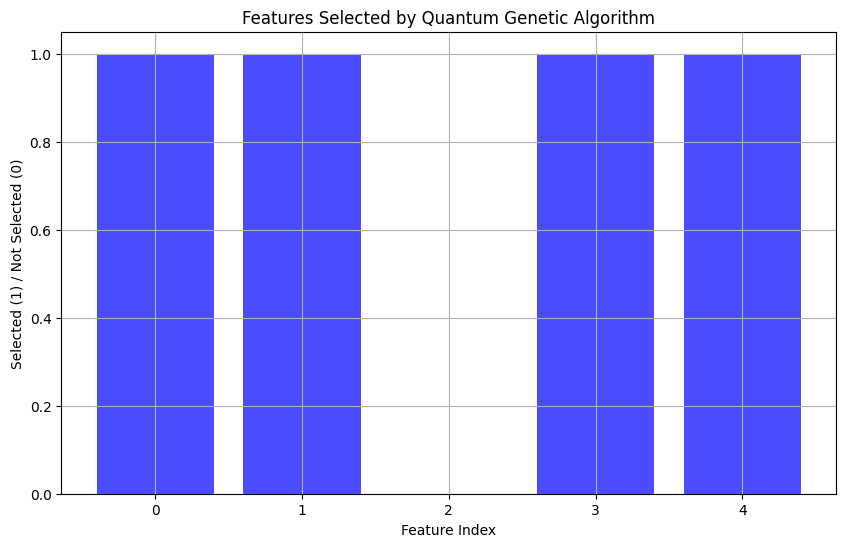

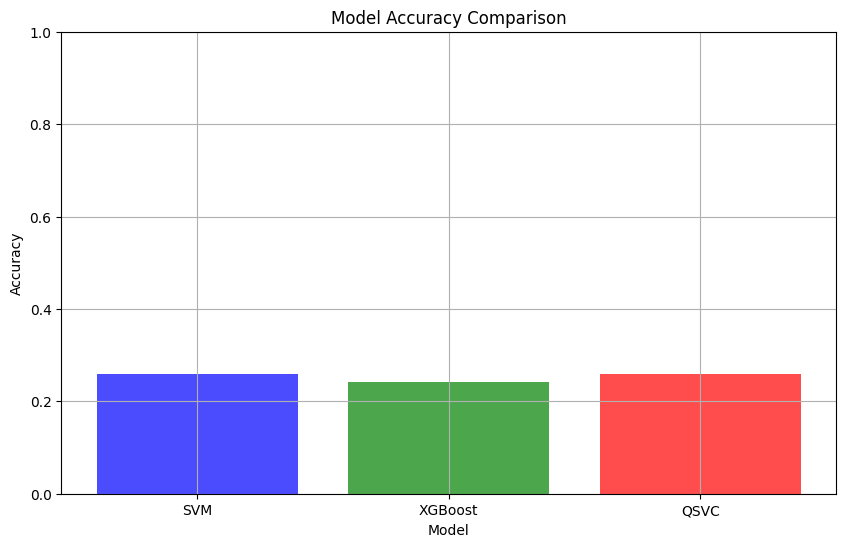

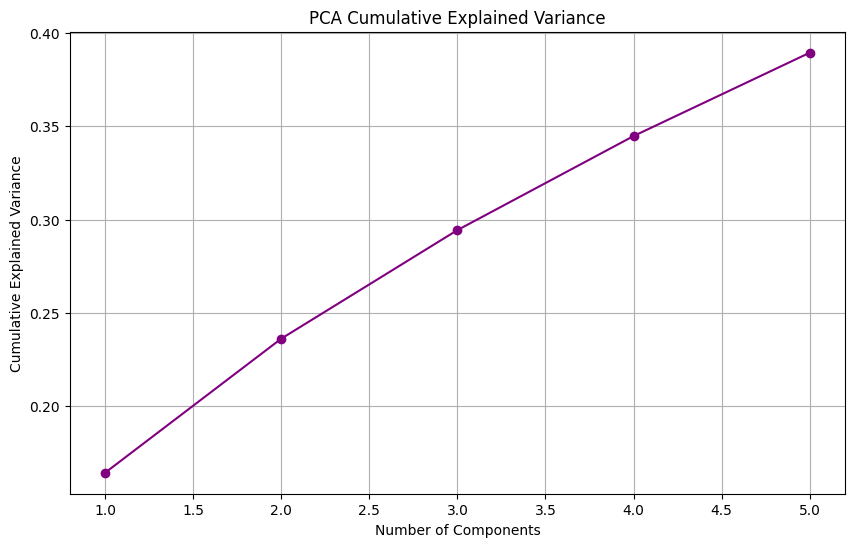

SVM Accuracy: 25.86%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.25      0.29      0.27        14
           2       0.54      0.33      0.41        21
           3       0.22      0.40      0.29        10

    accuracy                           0.26        58
   macro avg       0.25      0.25      0.24        58
weighted avg       0.29      0.26      0.26        58

XGBoost Accuracy: 24.14%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.15      0.15        13
           1       0.24      0.36      0.29        14
           2       0.33      0.14      0.20        21
           3       0.27      0.40      0.32        10

    accuracy                           0.24        58
   macro avg       0.25      0.26      0.24        58
weighted avg       0.26      0.24      0.23        58

QSVC Accuracy: 25.86%
QSVC

In [3]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
selected_features_indices_qga = qga.fit(X_train_reduced, y_train)

# Ensure selected features indices are a numpy array
selected_features_indices_qga = np.array(selected_features_indices_qga)

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga.astype(bool)]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga.astype(bool)]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

# Define the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

# Plot Feature Selection
def plot_feature_selection(selected_features_indices, num_features):
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), selected_features_indices, color='blue', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Selected (1) / Not Selected (0)')
    plt.title('Features Selected by Quantum Genetic Algorithm')
    plt.grid(True)
    plt.savefig('feature_selection_plot.png')  # Save plot
    plt.show()

# Plot and save feature selection
plot_feature_selection(selected_features_indices_qga.astype(int), X_train_reduced.shape[1])

# Plot Accuracy Comparison
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig('model_accuracy_comparison.png')  # Save plot
    plt.show()

# Accuracy scores for different models
models = ['SVM', 'XGBoost', 'QSVC']
accuracies = [svm_accuracy, xgb_accuracy, qsvc_accuracy]

# Plot and save accuracy comparison
plot_accuracy_comparison(models, accuracies)

# Plot PCA Component Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('pca_variance_plot.png')  # Save plot
    plt.show()

# Plot and save PCA variance
plot_pca_variance(pca)

# Print model evaluations
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Classification Report:\n{svm_report}')

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{xgb_report}')

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
selected_features_indices_qga = qga.fit(X_train_reduced, y_train)

# Ensure selected features indices are a numpy array
selected_features_indices_qga = np.array(selected_features_indices_qga)

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga.astype(bool)]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga.astype(bool)]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

# Define the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

# Plot Feature Selection
def plot_feature_selection(selected_features_indices, num_features):
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), selected_features_indices, color='blue', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Selected (1) / Not Selected (0)')
    plt.title('Features Selected by Quantum Genetic Algorithm')
    plt.grid(True)
    plt.savefig('feature_selection_plot.png')  # Save plot
    plt.show()

# Plot and save feature selection
plot_feature_selection(selected_features_indices_qga.astype(int), X_train_reduced.shape[1])

# Plot Accuracy Comparison
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig('model_accuracy_comparison.png')  # Save plot
    plt.show()

# Accuracy scores for different models
models = ['SVM', 'XGBoost', 'QSVC']
accuracies = [svm_accuracy, xgb_accuracy, qsvc_accuracy]

# Plot and save accuracy comparison
plot_accuracy_comparison(models, accuracies)

# Plot PCA Component Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('pca_variance_plot.png')  # Save plot
    plt.show()

# Plot and save PCA variance
plot_pca_variance(pca)

# Print model evaluations
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Classification Report:\n{svm_report}')

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{xgb_report}')

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/tmp/ipykernel_1498973/1855593884.py:27: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  X_selected = X[:, np.where(individual == 1)[0]]
/opt/conda/envs/cuquantum-24.03/li

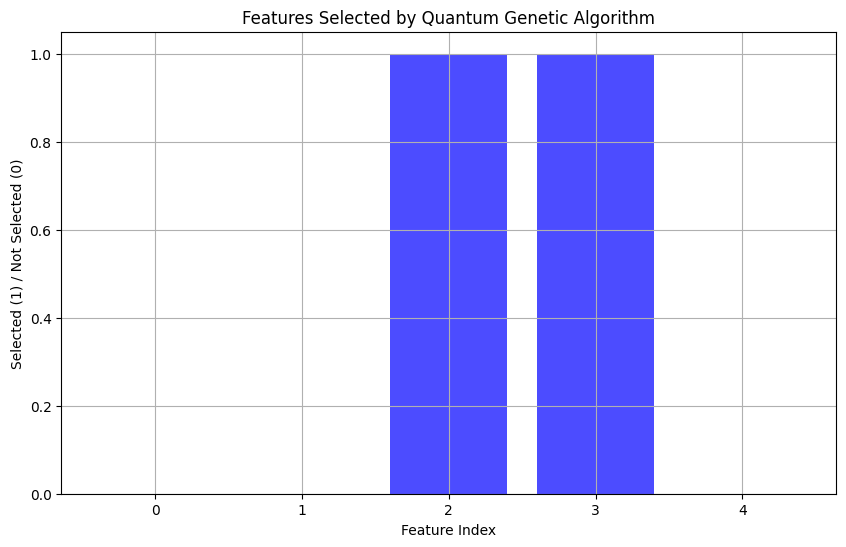

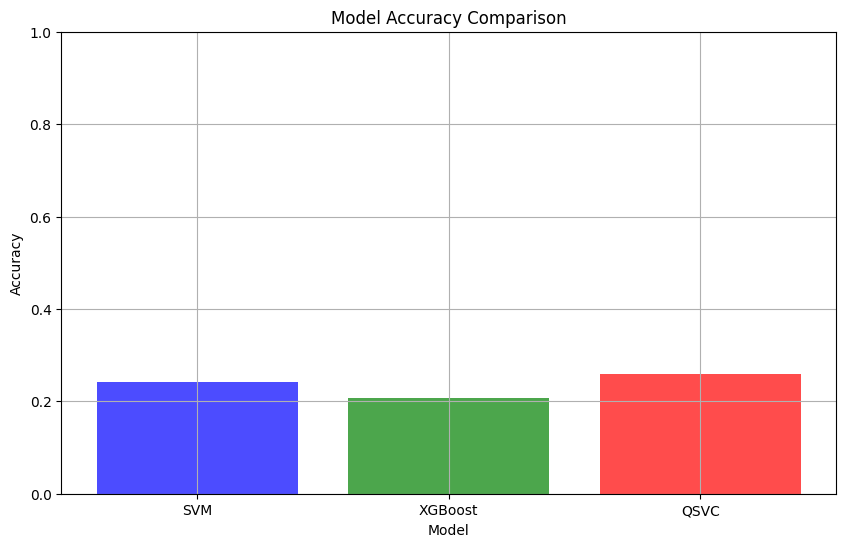

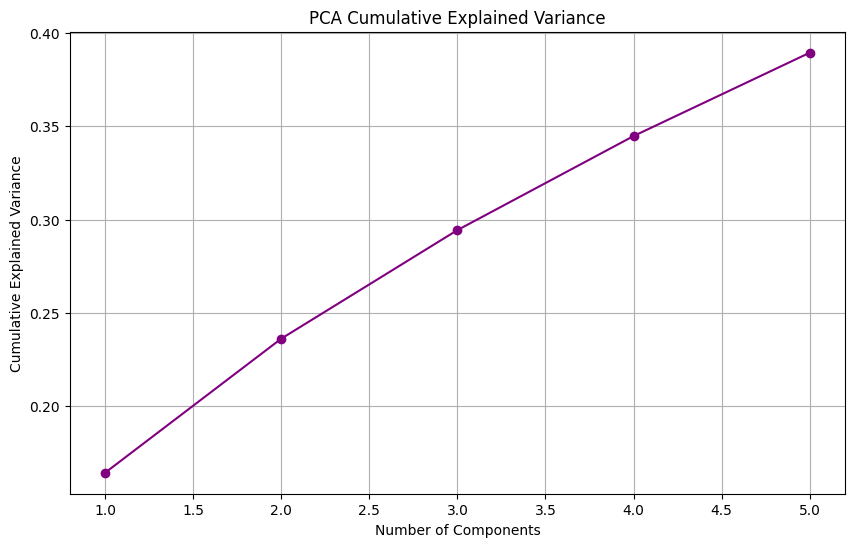

SVM Accuracy: 24.14%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.21      0.29      0.24        14
           2       0.33      0.19      0.24        21
           3       0.24      0.60      0.34        10

    accuracy                           0.24        58
   macro avg       0.20      0.27      0.21        58
weighted avg       0.21      0.24      0.21        58

XGBoost Accuracy: 20.69%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.23      0.19        13
           1       0.25      0.29      0.27        14
           2       0.60      0.14      0.23        21
           3       0.11      0.20      0.14        10

    accuracy                           0.21        58
   macro avg       0.28      0.21      0.21        58
weighted avg       0.33      0.21      0.22        58

QSVC Accuracy: 25.86%
QSVC

In [4]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from deap import base, creator, tools

# Define the genetic algorithm for feature selection
class QuantumGeneticAlgorithm:
    def __init__(self, population_size=50, generations=20, cxpb=0.1, mutpb=0.05):
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

    def evaluate(self, individual, X, y):
        # Evaluate the individual
        X_selected = X[:, np.where(individual == 1)[0]]
        if X_selected.shape[1] == 0:
            return (0,)  # Avoid division by zero
        clf = SVC()
        clf.fit(X_selected, y)
        accuracy = clf.score(X_selected, y)
        return (accuracy,)

    def fit(self, X, y):
        num_features = X.shape[1]
        
        # Create types
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", np.random.randint, 2)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", self.evaluate, X=X, y=y)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        population = toolbox.population(n=self.population_size)
        
        for generation in range(self.generations):
            offspring = toolbox.select(population, len(population))
            offspring = list(map(toolbox.clone, offspring))
            
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if np.random.random() < self.cxpb:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values
            
            for mutant in offspring:
                if np.random.random() < self.mutpb:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values
            
            invalid_ind = [ind for ind in population if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            population[:] = offspring
        
        best_individual = tools.selBest(population, 1)[0]
        return best_individual

# Load the .mat file
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')

# Extract features and labels
X = data['features']   # Correct variable name for features
y = data['labels']     # Correct variable name for labels

# Convert complex values to real if necessary
X = np.real(X)

# Normalize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure labels are a 1D array
y = y.flatten()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)  # Adjust the number of components as needed
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)  # Transform test data with the same PCA

# Apply QGA for feature selection
qga = QuantumGeneticAlgorithm(population_size=20, generations=10)
best_individual = qga.fit(X_train_reduced, y_train)

# Extract the selected features
selected_features_indices_qga = np.where(np.array(best_individual) == 1)[0]

# Select features
X_train_reduced_selected = X_train_reduced[:, selected_features_indices_qga]
X_test_reduced_selected = X_test_reduced[:, selected_features_indices_qga]

# Define and train SVM model
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train_reduced_selected, y_train)

# Predict with SVM
svm_predicted_labels = svm_model.predict(X_test_reduced_selected)

# Evaluate SVM model
svm_accuracy = accuracy_score(y_test, svm_predicted_labels)
svm_report = classification_report(y_test, svm_predicted_labels)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_reduced_selected, y_train)

# Predict with XGBoost
xgb_predicted_labels = xgb_model.predict(X_test_reduced_selected)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_predicted_labels)
xgb_report = classification_report(y_test, xgb_predicted_labels)

# Define the quantum feature map with 8 qubits
feature_map = ZZFeatureMap(feature_dimension=X_train_reduced_selected.shape[1], entanglement='linear')

# Define the quantum kernel
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Initialize QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Train the QSVC
qsvc.fit(X_train_reduced_selected, y_train)

# Predict on test data
qsvc_predicted_labels = qsvc.predict(X_test_reduced_selected)

# Evaluate QSVC model
qsvc_accuracy = accuracy_score(y_test, qsvc_predicted_labels)
qsvc_report = classification_report(y_test, qsvc_predicted_labels)

# Plot Feature Selection
def plot_feature_selection(selected_features_indices, num_features):
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features), selected_features_indices, color='blue', alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Selected (1) / Not Selected (0)')
    plt.title('Features Selected by Quantum Genetic Algorithm')
    plt.grid(True)
    plt.savefig('feature_selection_plot.png')  # Save plot
    plt.show()

# Plot and save feature selection
plot_feature_selection(np.isin(range(X_train_reduced.shape[1]), selected_features_indices_qga).astype(int), X_train_reduced.shape[1])

# Plot Accuracy Comparison
def plot_accuracy_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig('model_accuracy_comparison.png')  # Save plot
    plt.show()

# Accuracy scores for different models
models = ['SVM', 'XGBoost', 'QSVC']
accuracies = [svm_accuracy, xgb_accuracy, qsvc_accuracy]

# Plot and save accuracy comparison
plot_accuracy_comparison(models, accuracies)

# Plot PCA Component Variance
def plot_pca_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', color='purple')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.savefig('pca_variance_plot.png')  # Save plot
    plt.show()

# Plot and save PCA variance
plot_pca_variance(pca)

# Print model evaluations
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM Classification Report:\n{svm_report}')

print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')
print(f'XGBoost Classification Report:\n{xgb_report}')

print(f'QSVC Accuracy: {qsvc_accuracy * 100:.2f}%')
print(f'QSVC Classification Report:\n{qsvc_report}')


In [2]:
import qiskit
import qiskit_machine_learning
print("Qiskit version:", qiskit.__version__)
print("Qiskit Machine Learning version:", qiskit_machine_learning.__version__)


Qiskit version: 1.1.0
Qiskit Machine Learning version: 0.7.2


/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


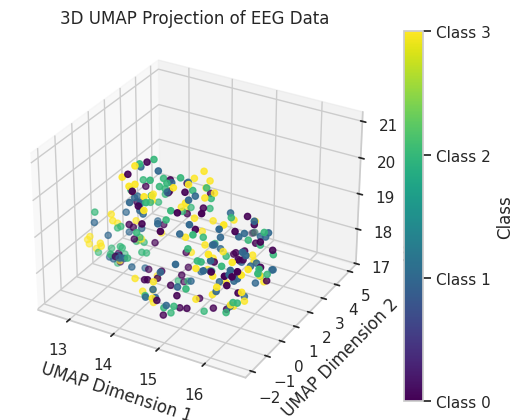

In [18]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Load the data
data = scipy.io.loadmat('data/BCICIV_2a_gdf/processed_features_vmd/combined_features_labels.mat')
X = data['features']
y = np.ravel(data['labels'])  # Flatten y to ensure it's a 1D array

# Ensure features are real
X = np.real(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP for 3D projection
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot the 3D UMAP projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each class
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=y, cmap='viridis', marker='o')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Class')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Set titles and labels
ax.set_title('3D UMAP Projection of EEG Data')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Save the plot with high resolution and no extra whitespace
plt.savefig('3d_umap_projection.png', dpi=300, bbox_inches='tight', pad_inches=0)
